# Notebook 2

## Mutliple Logistic Regression Modeling (ISLR Chapter 4)

This dataset using US Census data from the 2019 ACS 5 year survey along with COVID-19 vaccination rate data from the Louisiana Department of Health. Data is organized by census tract. The first portion of this Notebook is include the data cleaning and manipulation code. For logistic modeling teaching puropses, please start at [What is a binomial? What does it mean? Why are we using it?](#start_here).

In [1]:
import os
import pandas as pd

In [2]:
dir_main = os.getcwd()

In [3]:
dir_cleaning = os.path.join(dir_main, 'data', 'cleaning')

In [4]:
lst_names = os.listdir(dir_cleaning)
lst_names

lst_temp = []
for name in lst_names: # Filter system files out
    if not name.startswith('.'):
        lst_temp.append(name)
lst_names = lst_temp

In [5]:
lst_names

['ACSDT5Y2019.B08201_data_with_overlays_2021-06-15T154037.csv',
 'ACSST5Y2019.S2301_data_with_overlays_2021-06-15T114804.csv',
 'ACSDT5Y2019.B02001_data_with_overlays_2021-06-10T164336.csv',
 'ACSST5Y2019.S1501_data_with_overlays_2021-06-15T160409.csv',
 'ACSST5Y2019.S1901_data_with_overlays_2021-06-15T155942.csv']

In [6]:
lst_dfs = []
for name in lst_names:
    df_temp = pd.read_csv(os.path.join(dir_cleaning, name), header=None)
    
    df_temp.drop(df_temp.index[0], inplace=True) # Delete unneeded header
    new_header = df_temp.iloc[0] # Grab the first row for the header
    df_temp = df_temp[1:] # Take the data less the header row
    df_temp.columns = new_header # Set the header row as the df header
    
    lst_dfs.append(df_temp)

/Users/steele/opt/anaconda3/envs/ISLR/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,54

In [7]:
from functools import reduce

In [8]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='id'), lst_dfs) # Combine all dataframes together

In [9]:
df_stats = df_merged[['id',
                      'Labor Force Participation 16 and Older Percent',
                      'Median Household Income',
                      'Black Percent',
                      'No Vehicle Household Percent', 
                      'Population High School Graduate or Equivalency or Higher Percent']]

In [10]:
df_vac = pd.read_csv(os.path.join(dir_main, 'data', '2021.06.28_Vaccinations by Tract.csv'))

In [11]:
# Create column with percent vaccination series completed out of total population for census tract
df_vac['SeriesCompPercent'] = df_vac['SeriesComp']/df_vac['Total_2018Pop'] 

In [12]:
# Add full tract code to vaccination tracts
tracts = df_vac['TractID']
geoid = []
for tract in tracts:
    geoid.append('1400000US' + str(tract))
df_vac['id']  = geoid    

In [13]:
df_vac_orig = df_vac.copy(deep=True)

# Limit to only Orleans Parish
df_vac = df_vac[df_vac.parish == 'Orleans']

In [14]:
df_vac = df_vac[['id', 'Lat', 'Long', 'SeriesInt', 'SeriesComp', 'SeriesCompPercent']]

In [15]:
df = df_vac.merge(df_stats, on='id', copy=False)

### Changing Data Type
As shown below, we've got a mixture of datatypes. We'll need to change these to float in order to start creating models. 

In [16]:
df.dtypes

id                                                                   object
Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                       object
Median Household Income                                              object
Black Percent                                                        object
No Vehicle Household Percent                                         object
Population High School Graduate or Equivalency or Higher Percent     object
dtype: object

In [17]:
# The linear modeling will require int or float instead of objects,
# so we will convert the columns to numeric.
column_temp = df['id']
df.drop(columns='id', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') # Convert all columns to numeric
df['id'] = column_temp

df.dtypes

Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                      float64
Median Household Income                                             float64
Black Percent                                                       float64
No Vehicle Household Percent                                        float64
Population High School Graduate or Equivalency or Higher Percent    float64
id                                                                   object
dtype: object

In [18]:
df.describe()

,Lat,Long,SeriesInt,SeriesComp,SeriesCompPercent,Labor Force Participation 16 and Older Percent,Median Household Income,Black Percent,No Vehicle Household Percent,Population High School Graduate or Equivalency or Higher Percent
count,177.000000,177.000000,168.000000,168.00000,168.000000,174.000000,170.000000,174.000000,172.000000,174.000000
mean,29.971739,-90.057728,1096.696429,1002.87500,0.456262,61.945402,48814.541176,56.397553,20.184876,85.506897
std,0.041055,0.056683,536.080081,488.38913,0.148525,11.515823,31899.207159,32.718965,14.593598,10.522432
min,29.898550,-90.135307,214.000000,190.00000,0.075517,0.000000,10288.000000,0.901172,0.000000,55.900000
25%,29.939842,-90.099388,746.250000,667.75000,0.346976,55.150000,25073.000000,24.274568,8.683670,78.625000
50%,29.965729,-90.070679,995.000000,908.50000,0.431049,62.450000,39654.000000,67.377099,17.044145,86.650000
75%,29.997370,-90.032219,1378.750000,1234.00000,0.576862,70.475000,66384.250000,85.722305,29.486389,94.950000
max,30.121422,-89.752693,3972.000000,3309.00000,1.157398,83.700000,170278.000000,98.889755,65.775401,100.000000


<a id='start_here'></a>
### What is a binomial? What does it mean? Why are we using it?
<p>Logistic modeling is used for inferring or predicting something that has two outcomes.</p>
<p>In the example below, we can see how when we have two categories that linear regression might not be the best way to go about modeling. A line simply won't fit the data categories we have. Looking at logistic regression, we can approximate the dataset much easier much better. Is it perfect? Not at all. There is overlap between the values set to 1 and the values set to 0, but we will be able to better approximate the actual data using a log-based modeling aproach.</p>

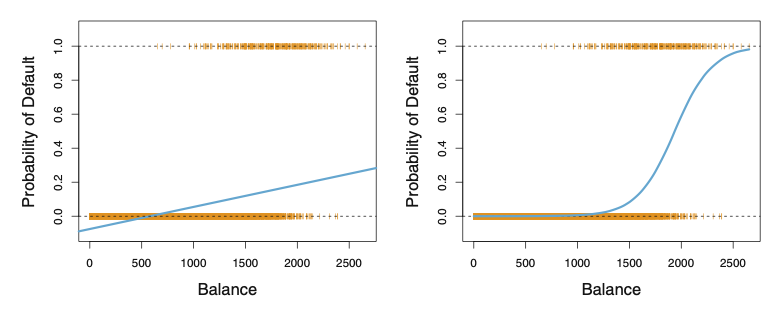

In this notebook we will split our <code>SeriesCompPercent</code> outcome variable into two categories, a <b>binomial</b> variable. </p>

<p>The census tracts that have a <code>SeriesCompPercent</code> will be categorized into a new outcome variable called <code>SeriesCompCat</code>. Census tracts with less than or equal to 40% of the population with a complete vaccination series will be given the value of 1, and the census tracts that have greater than 40% of their population vaccinated will be given a value of 0.</p>

<p>Important note: In this case we want to look at census tracts with low vaccination rates. On average, ceneus tracts in our dataset have 46% of their population vaccinated. 

In [19]:
df['SeriesCompCat'] = df['SeriesCompPercent']
# Set a binary outcome variable we will be modeling for
df['SeriesCompCat'] = df['SeriesCompCat'].le(0.40) # .le() is setting all values less than or equal to 0.4 to True
# Setting the column to an int type will mean <= 0.4 is 1 and > 0.4 is 0
df['SeriesCompCat'] = df['SeriesCompCat'].astype(int)

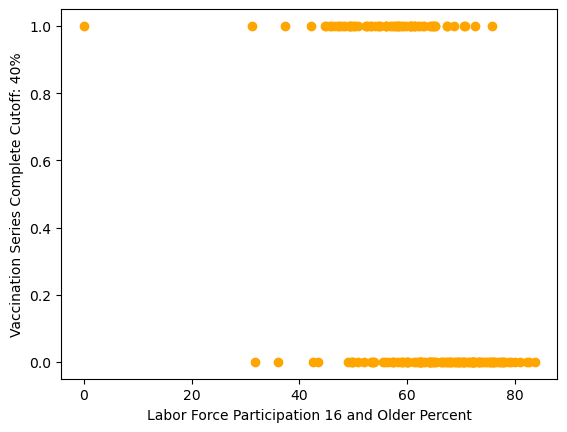

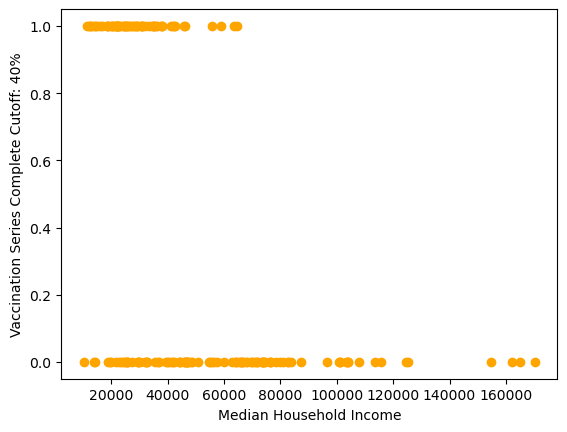

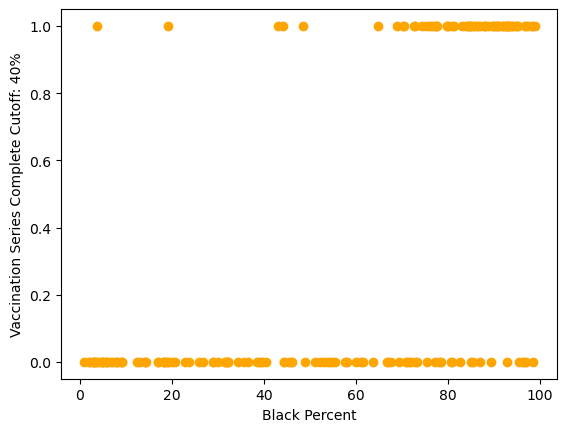

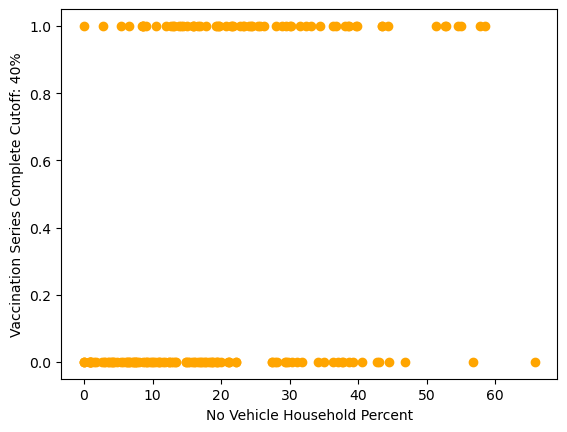

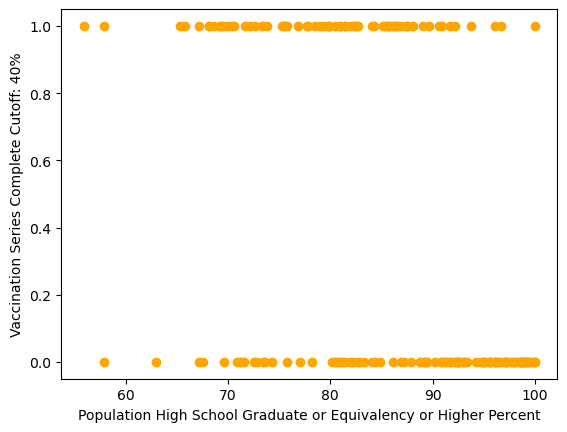

In [20]:
import matplotlib.pyplot as plot
import numpy as np

df_plots = df[df.columns[5:10]]

for i, col in enumerate(df_plots.columns):
    plot.scatter(df_plots[col], df['SeriesCompCat'], color='orange')
    plot.xlabel(df_plots[col].name)
    plot.ylabel('Vaccination Series Complete Cutoff: 40%')
    plot.show()

### Looking at our predictors

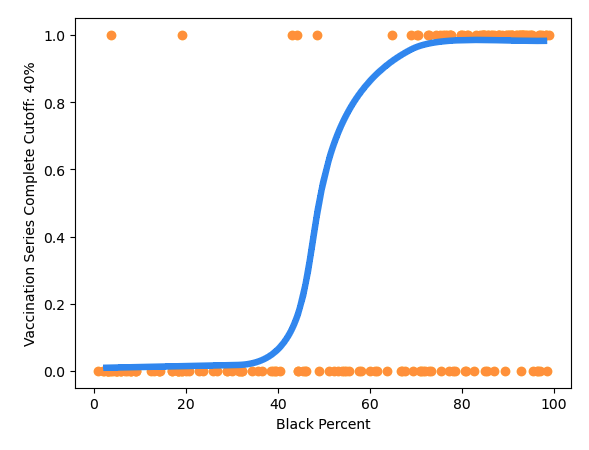

### Statsmodels

Now let's start creating some models.

In [21]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

### First Logistic Model

<p>In linear modeling we used <code>smf.ols()</code>, where ols stands for ordinary least squares regression modeling. For logistic modeling, we are using <code>smf.glm()</code> where glm stands for generalize linear model. Also note we need to specify <code>family=sm.families.Binomial()</code> in order to fit a binomial logistic model.</p>


In [22]:
model_1 = '''SeriesCompCat ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Labor Force Participation 16 and Older Percent") + 
            Q("Population High School Graduate or Equivalency or Higher Percent") +
            Q("Black Percent")'''
est_1 = smf.glm(model_1, family=sm.families.Binomial(), data=df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          SeriesCompCat   No. Observations:                  170
Model:                            GLM   Df Residuals:                      164
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66.103
Date:                Wed, 21 Jul 2021   Deviance:                       132.21
Time:                        12:03:23   Pearson chi2:                     142.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 0.8900      3.881      0.229      0.819      -6.717       8.497
Q("No Vehicle Household Percent")                                        -0.0410      0.025     -1.614      0.107      -0.091       0.009
Q("Median Household Income")                                          -4.912e-05   2.56e-05     -1.921      0.055   -9.92e-05    9.85e-07
Q("Labor Force Participation 16 and Older Percent")                      -0.0454      0.028     -1.646      0.100      -0.099       0.009
Q("Population High School Graduate or Equivalency or Higher Percent")     0.0178      0.036      0.491      0.623      -0.053       0.089
Q("Black Percent")                                                        0.0433      0.014      3.167      0.002       0.016       0.070
=========================================================================================================================================
"""

<p>Take a look at the results and see what you can tell abou the data from what we learned in the previous notebook on linear modeling. What predictors are statistically significant?</p>

### What does it tell us?

<p>A single log model results are not possible to interpret as to how well the model fits using just the summary results. We can say that <code>Population High School Graducate or Equivalency or Higher Percent</code> and <code>Labor Force Participation 16 and Older Percent</code> are not significant by observing that their <b>p-values</b> are greater than 0.05.</p>

### What else doe sit tell us?
<p> The other important part of the results to pay attention to is the <b>Log-Likelihood</b>.

In [23]:
model_1 = '''SeriesCompCat ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Labor Force Participation 16 and Older Percent") + 
            Q("Population High School Graduate or Equivalency or Higher Percent") +
            Q("Black Percent")'''
est_1 = smf.logit(model_1, df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_1.summary()

Optimization terminated successfully.
         Current function value: 0.388838
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          SeriesCompCat   No. Observations:                  170
Model:                          Logit   Df Residuals:                      164
Method:                           MLE   Df Model:                            5
Date:                Wed, 21 Jul 2021   Pseudo R-squ.:                  0.4201
Time:                        12:03:23   Log-Likelihood:                -66.103
converged:                       True   LL-Null:                       -113.99
Covariance Type:            nonrobust   LLR p-value:                 4.085e-19
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 0.8900      3.881      0.229      0.819      -6.717       8.497
Q("No Vehicle Household Percent")                                        -0.0410      0.025     -1.614      0.107      -0.091       0.009
Q("Median Household Income")                                          -4.912e-05   2.56e-05     -1.921      0.055   -9.92e-05    9.85e-07
Q("Labor Force Participation 16 and Older Percent")                      -0.0454      0.028     -1.646      0.100      -0.099       0.009
Q("Population High School Graduate or Equivalency or Higher Percent")     0.0178      0.036      0.491      0.623      -0.053       0.089
Q("Black Percent")                                                        0.0433      0.014      3.167      0.002       0.016       0.070
=========================================================================================================================================
"""

In [24]:
model_1 = '''SeriesCompCat ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Black Percent")'''
est_1 = smf.logit(model_1, df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_1.summary()

Optimization terminated successfully.
         Current function value: 0.397232
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          SeriesCompCat   No. Observations:                  170
Model:                          Logit   Df Residuals:                      166
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Jul 2021   Pseudo R-squ.:                  0.4076
Time:                        12:03:23   Log-Likelihood:                -67.529
converged:                       True   LL-Null:                       -113.99
Covariance Type:            nonrobust   LLR p-value:                 5.143e-20
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5944      1.993     -0.298      0.765      -4.500       3.311
Q("No Vehicle Household Percent")    -0.0399      0.023     -1.724      0.085      -0.085       0.005
Q("Median Household Income")      -5.312e-05   2.53e-05     -2.097      0.036      -0.000   -3.46e-06
Q("Black Percent")                    0.0477      0.014      3.505      0.000       0.021       0.074
=====================================================================================================
"""

In [25]:
model_2 = '''SeriesCompCat ~ 
            Q("Black Percent")'''
est_2 = smf.logit(model_2, df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_2.summary()

Optimization terminated successfully.
         Current function value: 0.418942
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          SeriesCompCat   No. Observations:                  174
Model:                          Logit   Df Residuals:                      172
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Jul 2021   Pseudo R-squ.:                  0.3739
Time:                        12:03:23   Log-Likelihood:                -72.896
converged:                       True   LL-Null:                       -116.42
Covariance Type:            nonrobust   LLR p-value:                 1.054e-20
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.7698      0.786     -6.066      0.000      -6.311      -3.229
Q("Black Percent")     0.0660      0.010      6.391      0.000       0.046       0.086
======================================================================================
"""

<p>Creating a new dataframe with a Black population of 95% as a predictor for a census tract, we can see what results our model gives.</p>

<p>In this case, the probability of the census tract having less than or equal to 40% of the population vaccinatied fully vaccinated is 81.8%.</p>

<p>Note: Previously less than or equal to 40% was set to to 1 and less to 0. The <code>predict()</code> function gives the probability of the outcome variable being 1 based on the predictor we given.</p>

In [26]:
newpred = pd.DataFrame({'Black Percent': [95]})
est_2.predict(newpred)

0    0.817581
dtype: float64

<p>Going to the other extreme and using a Black population of only 3%, the prediction is that the liklihood 
    

In [27]:
newpred = pd.DataFrame({'Black Percent': [3]})
est_2.predict(newpred)

0    0.010234
dtype: float64

In [28]:
df

,Lat,Long,SeriesInt,SeriesComp,SeriesCompPercent,Labor Force Participation 16 and Older Percent,Median Household Income,Black Percent,No Vehicle Household Percent,Population High School Graduate or Equivalency or Higher Percent,id,SeriesCompCat
0,29.953106,-90.052071,1281.0,1201.0,0.439122,68.1,78500.0,9.133127,4.200323,99.1,1400000US22071000100,0
1,29.945894,-90.052353,472.0,438.0,0.257042,67.4,27125.0,72.878536,25.364964,81.4,1400000US22071000200,1
2,29.940950,-90.048988,452.0,403.0,0.319082,72.5,35031.0,90.227774,33.059548,85.7,1400000US22071000300,1
3,29.946333,-90.042480,865.0,787.0,0.405252,62.9,39271.0,78.575116,22.180917,86.1,1400000US22071000400,0
4,29.932783,-90.040955,289.0,253.0,0.310049,50.1,11973.0,97.481637,30.174564,68.1,1400000US22071000601,1
...,...,...,...,...,...,...,...,...,...,...,...,...
172,29.913809,-90.114716,978.0,921.0,0.534533,77.1,66250.0,25.822168,7.539683,92.5,1400000US22071014400,0
173,29.960629,-90.095009,214.0,190.0,0.075517,0.0,NaN,84.785493,NaN,55.9,1400000US22071014500,1
174,30.001497,-90.093094,NaN,NaN,NaN,50.0,NaN,20.000000,NaN,100.0,1400000US22071980000,0
175,30.004488,-89.915703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400000US22071980100,0


### Scikit-learn

Let's try to do the same thing using <code>Scikit-learn</code>. <code>Scikit-learn</code> is a more Pythonic library compared to <code>Statsmodels</code>. <code>Sklearn</code> will also allow us to build train a model, make predictions using simple functions from the library.</p>

<p>With <code>Scikit-learn</code> we will need to split the dataframe into the predictor (AKA independent or features) and outcome (AKA dependent or target) variables.</p>

<p>It must be noted that with <code>sklearn</code> we need to either impute missing data or drop them from the dataframe. <code>Statsmodels</code> automatically drops missing data from the dataframe before, but with <code>sklearn</code> we will need to do it manually. We are opting to not impute data for simplicity of this notebook.</p>

In [29]:
df_omit = df.dropna() # Drop rows with missing data

In [30]:
predictor_cols = ['Labor Force Participation 16 and Older Percent', 
                  'Median Household Income', 
                  'Black Percent',
                  'No Vehicle Household Percent',
                  'Population High School Graduate or Equivalency or Higher Percent']

X = df_omit[predictor_cols] # Features
y = df_omit.SeriesCompCat # Target variable

To train the model we'll use the <code>train_test_split()</code> function where we will be splitting the data into five parts where 20% will be used as testing data and 80% will be used for training.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [46]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() # Initiate the model
logreg.fit(X_train,y_train) # Fit the model with data 

y_pred=logreg.predict(X_test)
y_pred # y_pred contains the predictions we have made

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])

<p>The next step is to create a confusion matrix so we can see how well our predictions fit.</p>

In [33]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[15,  4],
       [ 5, 10]])

What does the confusion matrix tell us?
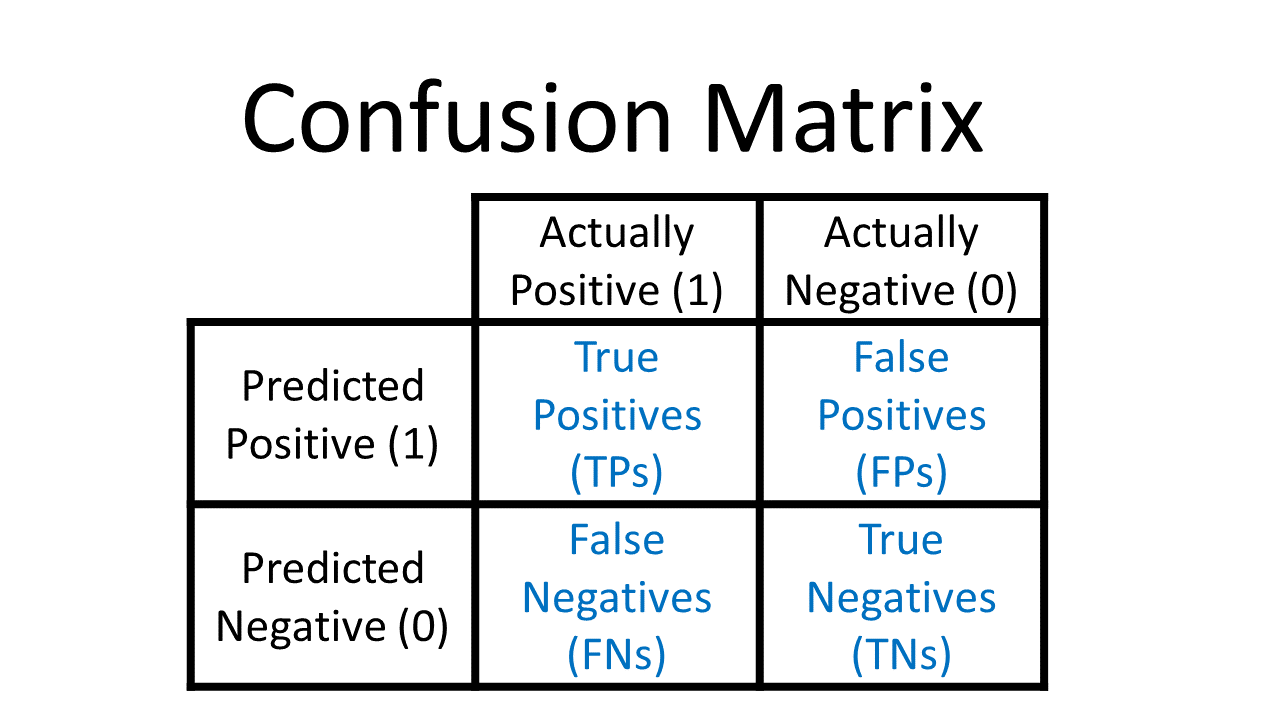

So... How good was the model? Let's look at the confusion <b>matrix evaluation metrics</b>.

In [34]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F-Measure:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.7352941176470589
Precision: 0.7142857142857143
Recall: 0.6666666666666666
F-Measure: 0.689655172413793


- <b>Accuracy:</b>
    - Ability of model to predict the both positives and negatives.
    - Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
- <b>Precision:</b>
    - Ability of model to predict the positives correctly out of all the predictions.
    - Precision Score = TP / (FP + TP)
- <b>Recall:</b>
    - Ability of the model to predict the positives correctly out of all the acutal positives.
    - Recall Score =  TP / (FN + TP)
- <b>F1 Score:</b>
    - A combination of both recall and precision.
    - F1 Score = (2 * Precision Score * Recall Score) / (Precision Score + Recall Score/)

#### So what do we want to say with all these matrix evaluation metrics? 

<p>Accuracy is generally the most familiar term. We can say our model is 74% accurate. That is to say that 74% of the time we will have correctly predicted the correct outcome. This is genearlly going to be the most understood metric for practical purposes. We are simply including precision, recall, and F1 score to show that it's possible to get that information as well. We're focused on practicality in this lesson, not statistics.</p>



#### But doesn't the model we built with <code>sklearn</code> using all the predictors when we determined they didn't matter?
<p>That's right. Let's try with just using the predictor that we determined to be the most important and see what we get.</p>

In [35]:
predictor_cols = ['Black Percent'] #### Using only Black Percent as the target (predictor) variable

X = df_omit[predictor_cols] # Features
y = df_omit.SeriesCompCat # Target variable

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [37]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() # Initiate the model
logreg.fit(X_train,y_train) # Fit the model with data 

y_pred=logreg.predict(X_test)

In [38]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[15,  4],
       [ 5, 10]])

In [39]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7352941176470589
Precision: 0.7142857142857143
Recall: 0.6666666666666666


As you can see, the accuracy, precision, and recall are all the same as the previous model. This is because <code>sklearn</code> automatically chose only the most important variable(s). In this case, <b>Black Percent</b> was the only reliable (statistically significant) predictor, just as we determined with <code>statsmodels</code>, so we are getting the same results as using all the predictors.</p>

#### Moving along to predicting with <code>sklearn</code>.

<p>Predicting with <code>sklearn</code> requires a one-dimensional <code>numpy</code> array as shown below.</p>

In [40]:
logreg.predict((np.array([90]).reshape(1,-1))) # With 90% black population

array([1])

<p>Alternatively, we can create our array as shown below to mitigate having to reshape.</p>

In [41]:
logreg.predict((np.array([[90]]))) # With 90% black population

array([1])

In [42]:
logreg.predict((np.array([50]).reshape(1,-1)))# With 50% black population

array([0])

#### What is the array returned telling us?

<p>When the array returns 1, our model is predicting that with <b>74% accuracy</b> that if the black population of a census tract is 90% the census tract will have a vaccination rate below 40%.</p>

<p>When we lower the black population to 50% we can say with <b>74% accuracy</b> that the census tract will have a vaccination rate above 40%.</p>



#### But we only testing on 20% of the data, that's not enough, right? Why wouldn't we want to test the rest of the data?

<p>Astute observation! That's right! Using only 20% of the data may be okay for a quick and dirty model or a model that uses a very large dataset, but we aren't making a quick and dirty model nor is our dataset very large. We can improve and get a more accuarate accuracy by running <b>cross validation</b> also known as <b>k-fold</b>.</p>

<p>K-fold is termed as such because we are folding the data on itself. We will be taking the data and splitting it into 5 parts. In the 1st fold the first 20% of the data will used as the testing data and the remaining 80% will be used as the training data. In the 2nd fold the 2nd 20% of the data will be used to test against the remaining 80% of the training data. The 3rd fold will use the 3rd 20% of the data as a test against predictions made by training with the remaining 80% of the data, and so on and so forth.</p>

<p>This is visualized below.</p>

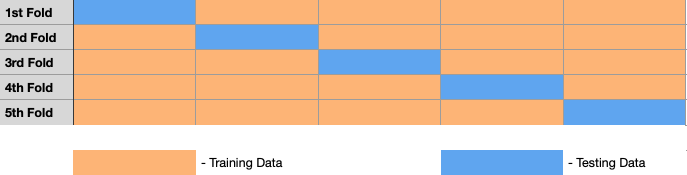

#### So let's try cross validation / k-folding

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv= KFold(n_splits=5, shuffle=True, random_state=1)
# We are splitting our data into 20% parts, so the number of spilts is 5
# shuffle=True will mix up the data before running the tests (is useful for some time series regression, but doesn't mater for our purposes)
# The random_state parameter is the seed for the random number generator (pesudo random number generator actually)

model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)

scores

array([0.91176471, 0.78787879, 0.87878788, 0.84848485, 0.75757576])

The array returned contains the results from each run. Due to the size of our dataset there is quite a bit of variation in the accuracies. So, let's average them out and get the standard deviation while we are at it.

In [44]:
import statistics
print('Accuracy: %.3f (%.3f)' % (statistics.mean(scores), np.std(scores)))

Accuracy: 0.837 (0.057)


#### Cross Validation / K-fold results

<p>Soooo, because we were only training on a portion of our data previously we were only getting 74% accuracy. By using all of the data to train the model, we can see that our accuracy increased to an average of 84%! That's quite an increase.</p>

<p>Note: It is also important that we consider our standard deviation of 0.057. We might want to take that and find the confidnece interval for our data to see the range our accuracy falls, but this is again getting more into statistics than we would like.</p>

<p>We can take this a step further by doing <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html">repeated k-folds</a>, but in our case it may be a bit overkill.</p>

#### Final thoughts

<p>Pretty simple, huh!?</p>

<p>So let's talk about how these two libraries work together. <code>Statsmodels</code> is where we want to begin exploring the data and seeing what predictors are the most important. We can see the p-values and results from other tests using <code>statsmodels</code>. This is where we get the evidence for building a model using a certain modeling technique and determining what predictors are significant and/or important.</p>

<p>This is not to say that <code>sklearn</code> can't be used for creating models, but the process is quite a bit more involved. <code>Statsmodels</code> is just going to give us a full report of the model we built, whereas <code>sklearn</code> requires us to specifically request certain tests and/or statistics relating to the built model.</p>

<p>Once we have a model built, we can move on to <code>sklearn</code> to make the job of cross validating the modelling technique and making predictions easier. In the example above we worked solely with binomial logistic regression, but the techniques for multinomial logistic, multiple linear, ordered logistic (ordinal), etc. are very similar.</p>

<p>This was just the tip of the iceberg of what <code>sklearn</code> has to offer. Check out the <a href="https://scikit-learn.org/stable/"><code>sklearn</code> documentation</a> to see what else is included in the library.</p>
